<a href="https://colab.research.google.com/github/falahamro/Moral-Foundations-Analysis/blob/main/Toxicity_Prediction_on_Republicans_and_Democrats_Election_Campain_Speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Application of Recurrent Neural Network in online comment toxicity detection and classification

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import re
import string
import itertools as it
import pickle
import os
from  pathlib import Path

import nltk
from nltk.corpus import stopwords                  # module for stop words that come with NLTK
from nltk.stem.wordnet import WordNetLemmatizer    # module for lemmatization
from nltk import word_tokenize, pos_tag            # tokenization and Part of Speech tagging

nltk.download('stopwords') #stopwords used to preprocess the corpus

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno
from scipy import interp
#import scikitplot as skplt
from itertools import cycle
import matplotlib.ticker as plticker

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.sparse import csr_matrix

import timeit, sys
from sklearn import metrics
import tqdm.notebook as tqdm
#from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import hamming_loss, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
#from scikitplot.metrics import plot_roc_curve

In [3]:
stopwords_english = stopwords.words('english') # list of English stopwords

Loading our datasets

In [4]:
from google.colab import drive
drive.mount('/content/dtive')

Mounted at /content/dtive


In [5]:
train_df = pd.read_csv("/content/dtive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/toxic_train.csv")
train_df['id'] = train_df[['id']].sum(axis=1).map(hash)


In [6]:
test_df = pd.read_csv("/content/dtive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/campaign.csv")
test_df.rename(columns = {'Candidate':'id'}, inplace=True)

test_df.rename(columns = {'Text':'comment_text'}, inplace=True)

test_df = test_df[["id", "comment_text"]]

In [7]:
test_label_data = pd.read_csv("/content/dtive/MyDrive/Colab Notebooks/Moral Foundations Application/Mapping Morals of Republicans and Democrats/test_labels.csv")
test_label_data['id'] = test_label_data[['id']].sum(axis=1).map(hash)


In [8]:
print("We have {} Rows and {} in our dataframe".format(train_df.shape[0], train_df.shape[1]))
train_df.head(10)

We have 159571 Rows and 8 in our dataframe


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,-4813681814856663581,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,5255197493500997872,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,-6386187218459025656,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,4581542260374916558,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,7706944993495073091,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,-1735123031461685749,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,-6987859676102351611,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,-2741689570215223778,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,1407312140568663799,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,1571326601639980123,alignment on this subject and which are contra...,0,0,0,0,0,0


Here is a look at the training dataset and can see that the dataframe has a total of 159571 rows and 8 columns. The id column has no weight except in labeling the remaining columns in binary labels. 

Column Description: 



*   id: a unique id aligned with each comment text. 
*   comment_text
*   toxic
*   severe_toxic
*   obscene
*   threat
*   insult
*   identity_hate






In [9]:
test_df

,id,comment_text
0,Jeb Bush,Thank you all very much. I always feel welcome...
1,Jeb Bush,Thank you all very much. I appreciate your hos...
2,Jeb Bush,Thank you very much. It's good to be with all ...
3,Jeb Bush,Thank you very much. I appreciate your hospita...
4,Jeb Bush,Thank you. It's great to be in Tampa with so m...
...,...,...
425,Donald Trump,"Thank you. Thank you very much, everyone. [app..."
426,Scott Walker,"I love America.As kids, my brother David and I..."
427,Scott Walker,"As a kid, I was drawn to Ronald Reagan because..."
428,Scott Walker,"My fellow Americans, you have a choice, you de..."


Our test data is significantly smaller than the training dataset. At this point, we're testing our model- we will be adding more contextualized data. 

In [10]:
train_df.isna().sum() # checking for missing values

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

We can confirm that there are no missing values in any of the columns present in the training dataset

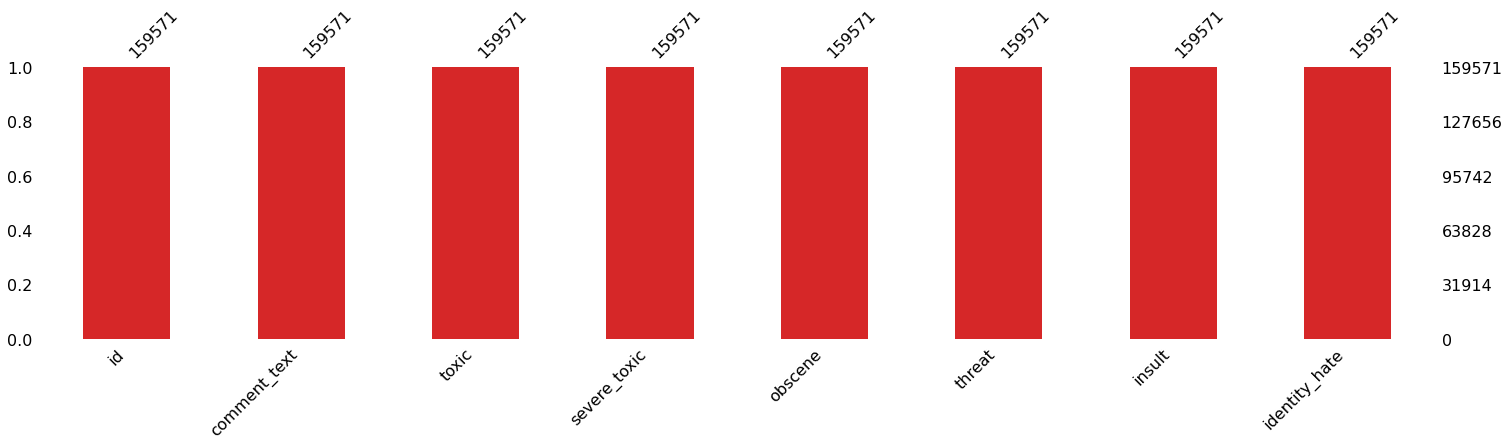

In [11]:
missingno.bar(train_df, figsize = (25,5), color="tab:red")

We get another confirmation with visuals that none of the columns in our dataset has any null values. 

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  int64 
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


Out of the 8 columns we have, 2 have object datatype while the remaining 6 columns are integer datatype. 

**Class imbalance in train set**

In [13]:
# checking ratio of data which contains toxic comments and normal or inoffensive comments.

output_labels = train_df.columns[2:]

# checking non-zero rows i.e: finding toxic comments 
toxic_comments = len(train_df[train_df[output_labels].any(axis=1)])

# counting rows containing zero i.e normal comments 

normal_comments = len(train_df)-toxic_comments

print(f"Total Toxic Comments: {toxic_comments} ({round(toxic_comments*100/len(train_df),2)}%)")
print(f"Total Normal Comments: {normal_comments} ({round(normal_comments*100/len(train_df),2)}%)")

Total Toxic Comments: 16225 (10.17%)
Total Normal Comments: 143346 (89.83%)


The ratio above shows that our dataframe consists of 10.17% of toxic comments and 89.83% of normal comments. Hence, it is clear that the dataset is imbalanced and needs to be treated accordingly during train test split of model training. 



**Number of occurrences of the label types**

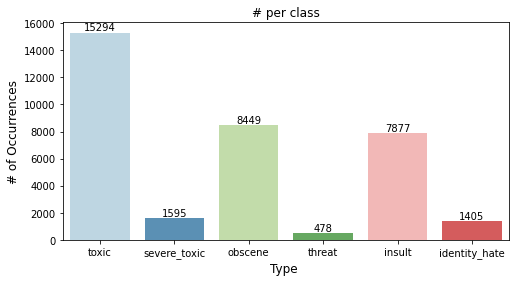

In [14]:
x = train_df.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette = "Paired")
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

# adding the text labels 
rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

View a sample of the testing data

In [15]:
for i in range (10):
  print(test_df['comment_text'][i])
  print('----------------------')

Thank you all very much. I always feel welcome at Miami-Dade College. This is a place that welcomes everyone with their hearts set on the future  a place where hope leads to achievement, and striving leads to success. For all of us, it is just the place to be in the campaign that begins today.We are 17 months from the time for choosing. The stakes for America's future are about as great as they come. Our prosperity and our security are in the balance. So is opportunity, in this nation where every life matters and everyone has the right to rise.Already, the choice is taking shape. The party now in the White House is planning a no-suspense primary, for a no-change election. To hold onto power. To slog on with the same agenda under another name: That's our opponents' call to action this time around. That's all they've got left.And you and I know that America deserves better.They have offered a progressive agenda that includes everything but progress. They are responsible for the slowest e

In [16]:
# checking the length of comments and storing it into another column 'original_length'
# we copy the train_df into another object df

df = train_df.copy()
df['original_length'] = df.comment_text.str.len()

# check the first five and last five rows here

df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
0,-4813681814856663581,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,5255197493500997872,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,-6386187218459025656,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,4581542260374916558,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,7706944993495073091,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,-3314598186227905581,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,-2726499282985641561,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,6333108564338644209,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,-2024190362310865489,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [17]:
#Let's check in the test.csv

test_label_data.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,9042484511145418598,-1,-1,-1,-1,-1,-1
1,-1559316937065330278,-1,-1,-1,-1,-1,-1
2,6996514264758744319,-1,-1,-1,-1,-1,-1
3,3441739907201807139,-1,-1,-1,-1,-1,-1
4,-7110278353452950019,-1,-1,-1,-1,-1,-1
5,-6313381631799429044,0,0,0,0,0,0
6,3724510493547175365,-1,-1,-1,-1,-1,-1
7,-4318945991312399786,0,0,0,0,0,0
8,3750080354699894219,-1,-1,-1,-1,-1,-1
9,-1202955763812382699,-1,-1,-1,-1,-1,-1


The test label dataset contains IDs and classification. -1 means IDs were not used for scoring. 

In [18]:
# The test label dataset will be ised to define the accuracy of the models. 

test_label_data = test_label_data.loc[test_label_data['toxic']!=-1]

In [19]:
# Let's calculate the % of toxic comments
test_label_data.iloc[:,1:-1].sum(axis=0) / test_label_data.shape[0]

toxic           0.095189
severe_toxic    0.005736
obscene         0.057692
threat          0.003298
insult          0.053565
dtype: float64

In [20]:
test_df['id'] = test_df[['id']].sum(axis=1).map(hash)

test_df

,id,comment_text
0,844960490738940176,Thank you all very much. I always feel welcome...
1,844960490738940176,Thank you all very much. I appreciate your hos...
2,844960490738940176,Thank you very much. It's good to be with all ...
3,844960490738940176,Thank you very much. I appreciate your hospita...
4,844960490738940176,Thank you. It's great to be in Tampa with so m...
...,...,...
425,-1371200097498002734,"Thank you. Thank you very much, everyone. [app..."
426,7715907835732122027,"I love America.As kids, my brother David and I..."
427,7715907835732122027,"As a kid, I was drawn to Ronald Reagan because..."
428,7715907835732122027,"My fellow Americans, you have a choice, you de..."


In [21]:
#let's group comments and classifications with IDs

test = test_label_data.merge(test_df, on='id', how="inner")

test.head(5)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text


**Data Cleaning**

In [22]:
# as the feature 'id' has no relevance w.r.t. model training I am dropping this column
df.drop(columns=['id'],inplace=True)
# converting comment text to lowercase format
df['comment_text'] = df.comment_text.str.lower()
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,264
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,112
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,233
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,67


Since there was no use of the "id" column I have dropped it and converted all the text data in our comment text column into lowercase format for easier interpretation



**Removing and Replacing unwanted characters in the comment_text column**


In [23]:
# Replacing '\n' with ' '
df.comment_text = df.comment_text.str.replace('\n',' ')

# Keeping only text with letters a to z, 0 to 9 and words like can't, don't, couldn't etc
df.comment_text = df.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Removing Stop Words and Punctuations

# Getting the list of stop words of english language as set
stop_words = set(stopwords.words('english'))

# Updating the stop_words set by adding letters from a to z
for ch in range(ord('a'),ord('z')+1):
    stop_words.update(chr(ch))
    
# Updating stop_words further by adding some custom words
custom_words = ("d'aww","mr","hmm","umm","also","maybe","that's","he's","she's","i'll","he'll","she'll","us",
                "ok","there's","hey","heh","hi","oh","bbq","i'm","i've","nt","can't","could","ur","re","ve",
                "rofl","lol","stfu","lmk","ily","yolo","smh","lmfao","nvm","ikr","ofc","omg","ilu")
stop_words.update(custom_words)

# Checking the new list of stop words
print("New list of custom stop words are as follows:\n\n")
print(stop_words)

New list of custom stop words are as follows:


{'needn', "you'd", "she's", 'having', 'ikr', 'l', 'once', 'am', 'most', 'own', 'him', 'should', 'his', 'herself', 'won', 'isn', "won't", 'ourselves', 'have', 'few', 'doing', 'again', 'such', "you've", 'o', "wouldn't", "doesn't", 'ma', "needn't", "weren't", 'umm', 'c', 'mr', 'whom', 'had', 'yours', 'below', 'q', 't', "aren't", 'an', "shouldn't", 'between', 'this', 'i', 'both', "couldn't", 'shouldn', 'hi', 'stfu', 'haven', 'some', 'at', 'there', 'who', 'while', 'my', 'here', 'against', "wasn't", 'lmfao', "it's", 'or', 'on', 'mustn', "isn't", 'those', 'before', "don't", 'your', 'did', 'b', 'us', 'hadn', "i'll", 's', 'ur', 'any', 'same', 'heh', 're', 'because', 'f', "that'll", 'couldn', 'ily', 'itself', 'is', 'being', 'by', 'y', 'g', 'for', 'himself', 'nt', 'only', 'above', 'didn', 'as', "mightn't", 'it', 'n', "you're", 'were', 'until', 'do', 'under', 'off', 'now', 've', 'hasn', 'was', "didn't", 'mightn', 'could', 'about', 'smh', 'will', 'of'

In [24]:
# Removing stop words
df.comment_text = df.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Removing punctuations
df.comment_text = df.comment_text.str.replace("[^\w\d\s]","")

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
3224,getting specifically far busby right things de...,0,0,0,0,0,0,752
116486,see bothers jew carlos slim helu lebanese spea...,0,0,0,0,0,0,343
26923,emmegan thanks efrain toro edits greatly appre...,0,0,0,0,0,0,138
137173,gotra called kapil gotra family belong kapila ...,0,0,0,0,0,0,128
155238,kakori train robbery considered act terrorism ...,0,0,0,0,0,0,274
83748,support suspicion link three trolls theyve tro...,0,0,0,0,0,0,533
86965,want know tell know everything jack,0,0,0,0,0,0,72
141272,helix saw entry eulers formula talk helix deta...,0,0,0,0,0,0,526
45995,agree killer poem really like rhythm poem poem...,0,0,0,0,0,0,551
75896,hello james greatful post first message ask ne...,0,0,0,0,0,0,156


In [25]:
# Stemming words
snb_stem = SnowballStemmer('english')
df.comment_text = df.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length
66313,matter much might wish true serious mental def...,0,0,0,0,0,0,219
154935,strang section intro articl introductori secti...,0,0,0,0,0,0,217
81063,georgian terrac hotel ad architectur detail hi...,0,0,0,0,0,0,404
2515,chuck todd made observ sarah quit summer bit a...,0,0,0,0,0,0,82
133295,fuck jew jew wine wine wine want money power h...,1,1,1,0,1,1,202
120455,bandera terrorist support terror keep stubborn...,1,0,0,0,0,0,468
103714,redirect talk cardiff citi season,0,0,0,0,0,0,46
8431,pleas stop ad nonsens wikipedia consid vandal ...,0,0,0,0,0,0,144
157589,thing think made differ self confid,0,0,0,0,0,0,92
135451,stop whine smelli littl turd know real wikiped...,1,0,1,0,1,0,394


In [26]:
# Checking the length of comment_text after cleaning and storing it in cleaned_length variable
df["cleaned_length"] = df.comment_text.str.len()

# Taking a loot at first 10 rows of data
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,original_length,cleaned_length
0,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,264,135
1,match background colour seem stuck thank talk ...,0,0,0,0,0,0,112,57
2,man realli tri edit war guy constant remov rel...,0,0,0,0,0,0,233,112
3,make real suggest improv wonder section statis...,0,0,0,0,0,0,622,310
4,sir hero chanc rememb page,0,0,0,0,0,0,67,26
5,congratul well use tool well talk,0,0,0,0,0,0,65,33
6,cocksuck piss around work,1,1,1,0,1,0,44,25
7,vandal matt shirvington articl revert pleas ban,0,0,0,0,0,0,115,47
8,sorri word nonsens offens anyway intend write ...,0,0,0,0,0,0,472,235
9,align subject contrari dulithgow,0,0,0,0,0,0,70,32


In [27]:
# Now checking the percentage of length cleaned
print(f"Total Original Length        : {df.original_length.sum()}")
print(f"Total Cleaned Length         : {df.cleaned_length.sum()}")
print(f"Percentage of Length Cleaned : {(df.original_length.sum()-df.cleaned_length.sum())*100/df.original_length.sum()}%")


Total Original Length        : 62882658
Total Cleaned Length         : 34297857
Percentage of Length Cleaned : 45.457367594098834%


**Visualization**

In [28]:
import pandas_profiling as pp


In [29]:
pandas_profiling.ProfileReport(df)

NameError: ignored

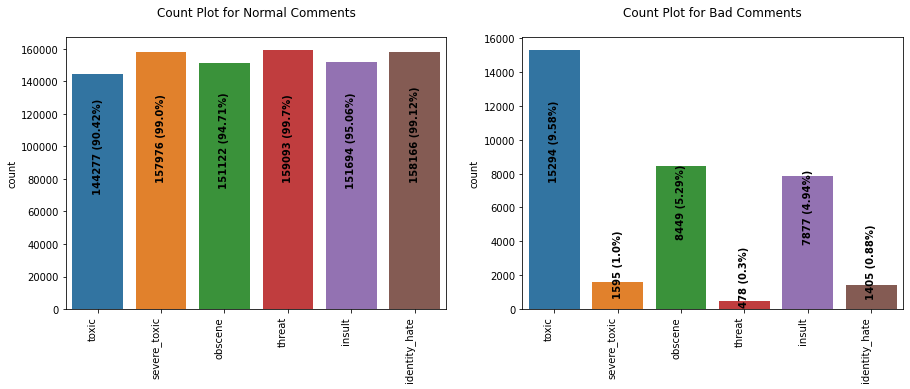

In [30]:
# comparing normal comments and bad comments using count plot

fig, ax = plt.subplots(1,2,figsize=(15,5))

for i in range(2):
    sns.countplot(data=df[output_labels][df[output_labels]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n")
    else:
        ax[i].set_title("Count Plot for Bad Comments\n")
        
    ax[i].set_xticklabels(output_labels, rotation=90, ha="right")
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1

plt.show()

Observation:

Dataset consists of higher number of Normal Comments than Bad or Malignant Comments. Therefore, it is clear that dataset is imbalanced and needs to be handle accordingly.
Most of the bad comments are of type malignant while least number of type threat is present in dataset.
Majority of bad comments are of type malignant, rude and abuse.

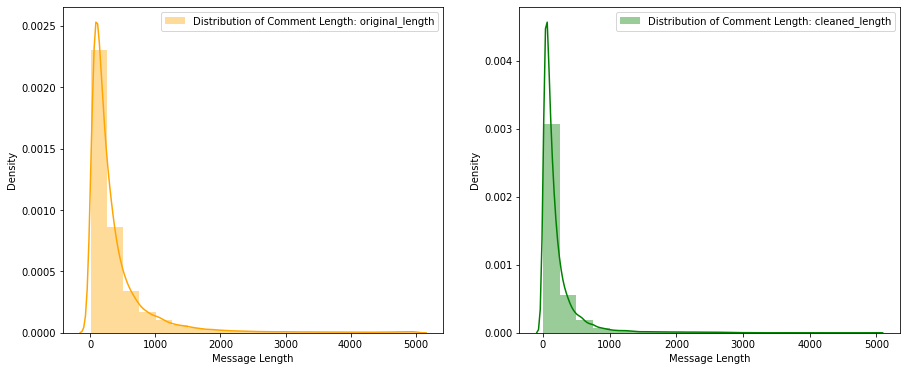

In [31]:
# Comparing the comment text length distribution before cleaning and after cleaning

fig, ax = plt.subplots(1,2,figsize=(15,6))
j=0
colors = ['orange','green']
for i in df.columns[-2:]:
    label_text = f"Distribution of Comment Length: {i}"
    sns.distplot(df[i],ax=ax[j],bins=20,color=colors[j],label=label_text)
    ax[j].set_xlabel("Message Length")
    ax[j].legend()
    j += 1
    
plt.show()

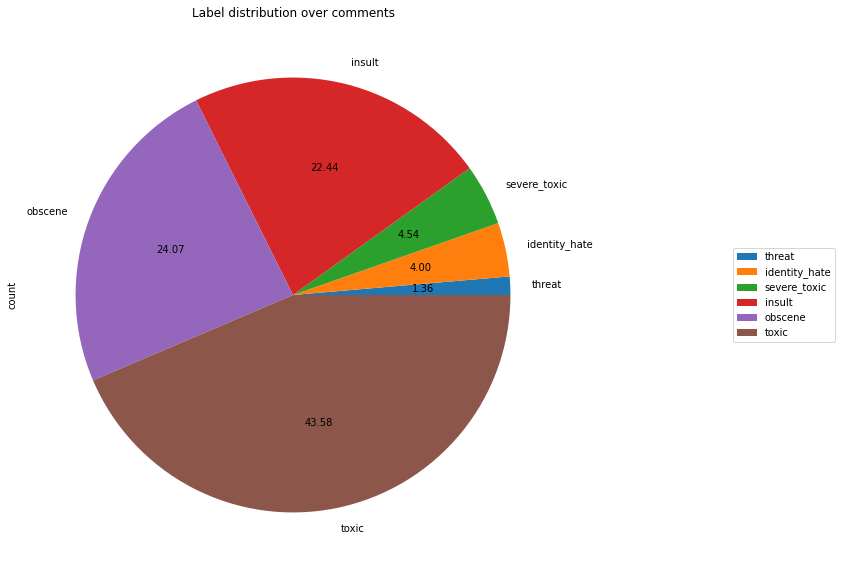

In [32]:
# Visualizing the label distribution of comments using pie chart

comments_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_distribution = train_df[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

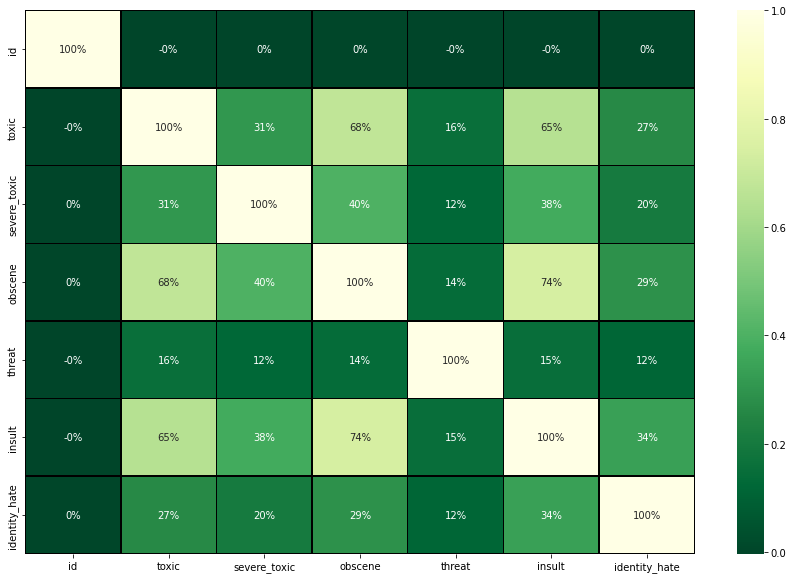

In [33]:
# Plotting heatmap for visualizing the correlation

plt.figure(figsize=(15, 10))
corr = train_df.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='YlGn_r', annot=True)
plt.show()

**WordCloud: Getting sense of cloud words in each of the output labels**


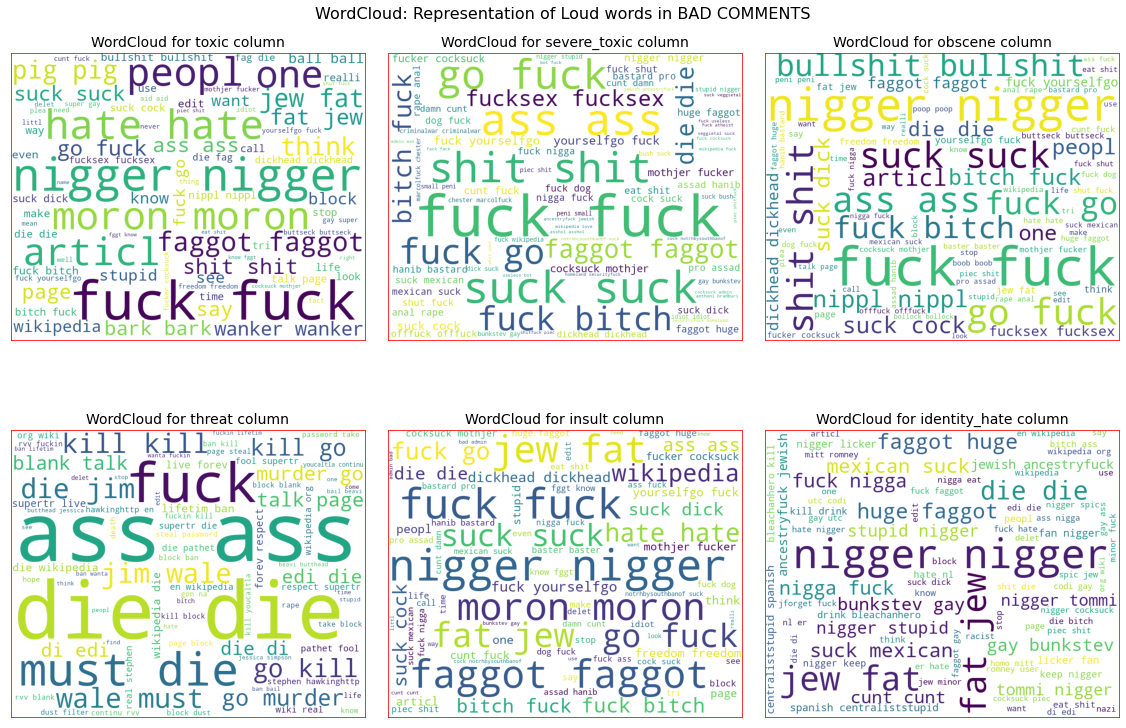

In [34]:
cols = 3
rows = len(output_labels)//cols
if len(output_labels) % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(16,rows*cols*1.8))
fig.subplots_adjust(top=0.8, hspace=0.3)

p=1
for i in output_labels:
    word_cloud = WordCloud(height=650, width=800,
                           background_color="white",max_words=80).generate(' '.join(df.comment_text[df[i]==1]))
    ax = fig.add_subplot(rows,cols,p)
    ax.imshow(word_cloud)
    ax.set_title(f"WordCloud for {i} column",fontsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor('r')
       
    ax.set_xticks([])
    ax.set_yticks([])
    p += 1

fig.suptitle("WordCloud: Representation of Loud words in BAD COMMENTS",fontsize=16)
fig.tight_layout(pad=2)
plt.show()

Observation:

From wordcloud of malignant comments, it is clear that it mostly consists of words like fuck, nigger, moron, hate, suck ect.
From wordcloud of highly_malignant comments, it is clear that it mostly consists of words like ass, fuck, bitch, shit, die, suck, faggot ect.
From wordcloud of rude comments, it is clear that it mostly consists of words like nigger, ass, fuck, suck, bullshit, bitch etc.
From wordcloud of threat comments, it is clear that it mostly consists of words like die, must die, kill, murder etc.
From wordcloud of abuse comments, it is clear that it mostly consists of words like moron, nigger, fat, jew, bitch etc.
From wordcloud of loathe comments, it is clear that it mostly consists of words like nigga, stupid, nigger, die, gay cunt etc.

**Data Preparation for Model Training and Testing**

1. Convert text to Vectors

In [35]:
# Converting text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=4000)
features = tfidf.fit_transform(df.comment_text).toarray()

# Checking the shape of features
features.shape

(159571, 4000)

2. Seperating Input and Output Variables

In [36]:
# input variables
X = features

# output variables
Y = csr_matrix(df[output_labels]).toarray()

# checking shapes of input and output variables to take care of data imbalance issue
print("Input Variable Shape:", X.shape)
print("Output Variable Shape:", Y.shape)

Input Variable Shape: (159571, 4000)
Output Variable Shape: (159571, 6)


**Classification Machine Learning Model Building**

3. Training and Testing Model on our train dataset

In [37]:
# Creating a function to train and test model
def build_models(models,x,y,test_size=0.33,random_state=42):
    # spliting train test data using train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=random_state)
    
    # training models using BinaryRelevance of problem transform
    for i in tqdm.tqdm(models,desc="Building Models"):
        start_time = timeit.default_timer()
        
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i} ")
        sys.stdout.write("\n=======================================================================================\n")
        
        br_clf = BinaryRelevance(classifier=models[i]["name"],require_dense=[True,True])
        print("Training: ",br_clf)
        br_clf.fit(x_train,y_train)
        
        print("Testing: ")
        predict_y = br_clf.predict(x_test)
        
        ham_loss = hamming_loss(y_test,predict_y)
        sys.stdout.write(f"\n\tHamming Loss  : {ham_loss}")
                
        ac_score = accuracy_score(y_test,predict_y)
        sys.stdout.write(f"\n\tAccuracy Score: {ac_score}")
        
        cl_report = classification_report(y_test,predict_y)
        sys.stdout.write(f"\n{cl_report}")
        
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        models[i]["trained"] = br_clf
        models[i]["hamming_loss"] = ham_loss
        models[i]["accuracy_score"] = ac_score
        models[i]["classification_report"] = cl_report
        models[i]["predict_y"] = predict_y
        models[i]["time_taken"] = end_time - start_time
                      
        sys.stdout.write("\n=======================================================================================\n")
    
    models["x_train"] = x_train
    models["y_train"] = y_train
    models["x_test"] = x_test
    models["y_test"] = y_test
    
    return models

In [38]:
from sklearn.model_selection import train_test_split

In [43]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 4.0 MB/s 


In [44]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [45]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

In [46]:
# Preparing the list of models for classification purpose
models = {"GaussianNB": {"name": GaussianNB()},
          "MultinomialNB": {"name": MultinomialNB()},
          "Logistic Regression": {"name": LogisticRegression()},
          "Random Forest Classifier": {"name": RandomForestClassifier()},
          "Support Vector Classifier": {"name": LinearSVC(max_iter = 3000)},
          "Ada Boost Classifier": {"name": AdaBoostClassifier()},
          "K Nearest Neighbors Classifier": {"name": KNeighborsClassifier()},
          "Decision Tree Classifier": {"name": DecisionTreeClassifier()},
          "Bagging Classifier": {"name": BaggingClassifier(base_estimator=LinearSVC())},
         }

# Taking one forth of the total data for training and testing purpose
half = len(df)//4
trained_models = build_models(models,X[:half,:],Y[:half,:])

Building Models:   0%|          | 0/9 [00:00<?, ?it/s]


Current Model in Progress: GaussianNB 
Training:  BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.21543233320673502
	Accuracy Score: 0.4730725408279529
              precision    recall  f1-score   support

           0       0.16      0.79      0.26      1281
           1       0.08      0.46      0.13       150
           2       0.11      0.71      0.19       724
           3       0.02      0.25      0.03        44
           4       0.10      0.65      0.17       650
           5       0.04      0.46      0.07       109

   micro avg       0.11      0.70      0.20      2958
   macro avg       0.08      0.55      0.14      2958
weighted avg       0.12      0.70      0.21      2958
 samples avg       0.05      0.07      0.05      2958
Completed in [14.289636636999944 sec.]

Current Model in Progress: MultinomialNB 
Training:  BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.02409

In [49]:
import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM
from keras.models import model_from_json

In [55]:
import torch
import torchvision

In [64]:
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.2


In [76]:
# selecting the best model
best_model = trained_models['MultinomialNB']['trained']

# saving the best classification model
joblib.dump(best_model,open('MultinomialNBMalignant_comments_classifier.pkl','wb'))

In [78]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Support Vector ClassifierMalignant_comments_classifier.pkl','wb'))

In [79]:
# selecting the best model
best_model = trained_models['GaussianNB']['trained']

# saving the best classification model
joblib.dump(best_model,open('GaussianNBMalignant_comments_classifier.pkl','wb'))

In [80]:
# selecting the best model
best_model = trained_models['Logistic Regression']['trained']

# saving the best classification model
joblib.dump(best_model,open('Logistic RegressionMalignant_comments_classifier.pkl','wb'))

In [81]:
# selecting the best model
best_model = trained_models['Random Forest Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Random Forest ClassifierMalignant_comments_classifier.pkl','wb'))

In [82]:
# selecting the best model
best_model = trained_models['Ada Boost Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Ada Boost ClassifierMalignant_comments_classifier.pkl','wb'))

In [83]:
# selecting the best model
best_model = trained_models['K Nearest Neighbors Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('K Nearest Neighbors ClassifierMalignant_comments_classifier.pkl','wb'))

In [84]:
# selecting the best model
best_model = trained_models['Decision Tree Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Decision Tree ClassifierMalignant_comments_classifier.pkl','wb'))

In [85]:
# selecting the best model
best_model = trained_models['Bagging Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Bagging ClassifierMalignant_comments_classifier.pkl','wb'))

In [87]:
import pickle

In [89]:

# save the model to disk
filename = 'models.sav'
pickle.dump(models, open(filename, 'wb')) 

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

**Hyperparameter Tuning**

In [90]:
# Choosing Linear Support Vector Classifier model

fmod_param = {'estimator__penalty' : ['l1', 'l2'],
              'estimator__loss' : ['hinge', 'squared_hinge'],
              'estimator__multi_class' : ['ovr', 'crammer_singer'],
              'estimator__random_state' : [42, 72, 111]
             }
SVC = OneVsRestClassifier(LinearSVC())
GSCV = GridSearchCV(SVC, fmod_param, cv=3)
x_train,x_test,y_train,y_test = train_test_split(X[:half,:], Y[:half,:], test_size=0.30, random_state=42)
GSCV.fit(x_train,y_train)
GSCV.best_params_

{'estimator__loss': 'hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': 42}

After comparing all the classification models I have selected Linear Support Vector Classifier as my best model and have listed down it's parameters above referring the sklearn webpage. I am using the Grid Search CV method for hyper parameter tuning my best model. I have trained the Grid Search CV with the list of parameters I feel it should check for best possible outcomes. So the Grid Search CV has provided me with the best parameters list out of all the combinations it used to train the model that I can use on my final model.

In [91]:
Final_Model = OneVsRestClassifier(LinearSVC(loss='hinge', multi_class='ovr', penalty='l2', random_state=42))
Classifier = Final_Model.fit(x_train, y_train)
fmod_pred = Final_Model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)
h_loss = hamming_loss(y_test,fmod_pred)*100
print("Hamming loss for the Best Model is:", h_loss)

Accuracy score for the Best Model is: 91.51069518716578
Hamming loss for the Best Model is: 1.9593917112299464


I have successfully incorporated the Hyper Parameter Tuning on my Final Model and received the accuracy score for it.



**AUC ROC Curve for Final Model**

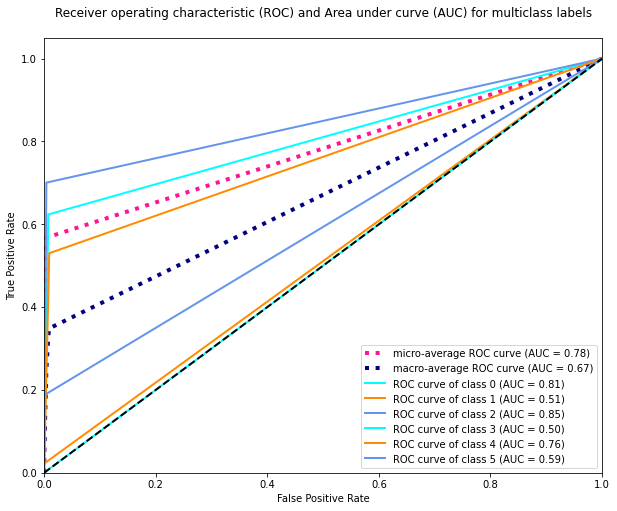

In [92]:
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], fmod_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), fmod_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) and Area under curve (AUC) for multiclass labels\n")
plt.legend(loc="lower right")
plt.show()

I have generated the ROC Curve for my final model and it shows separate curve for every class present in our multi label target variable along with it's AUC values.

**Confusion Matrix for Final Model**

In [93]:
print("Confusion matrix:\n\n", multilabel_confusion_matrix(y_test, fmod_pred))

Confusion matrix:

 [[[10710    83]
  [  442   733]]

 [[11832     1]
  [  132     3]]

 [[11263    47]
  [  197   461]]

 [[11930     0]
  [   38     0]]

 [[11266   106]
  [  280   316]]

 [[11869     3]
  [   78    18]]]


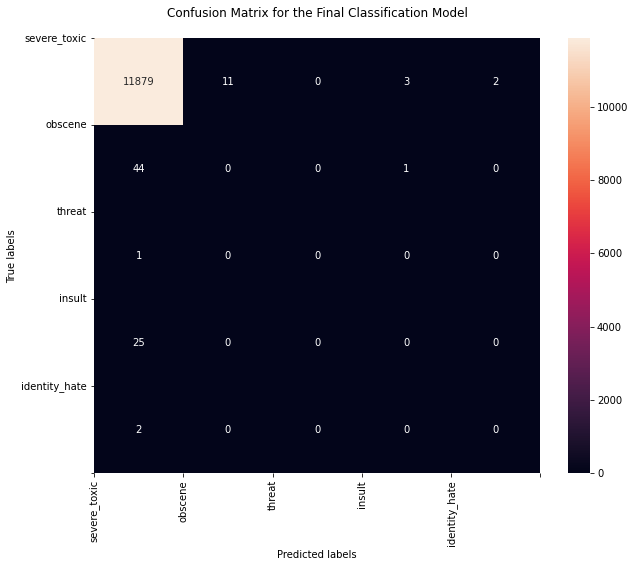

In [94]:
plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size
ax= plt.subplot()
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(fmod_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# title, labels and ticks
ax.set_title('Confusion Matrix for the Final Classification Model\n'); 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
loc = plticker.MultipleLocator()
ax.xaxis.set_major_locator(loc); ax.yaxis.set_major_locator(loc);
ax.set_xticklabels(comments_labels); ax.set_yticklabels(comments_labels);
plt.xticks(rotation=90); plt.yticks(rotation=0);
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my final model missed to provide the correct prediction (depicting in the black boxes).

**Model Saving or Serialization**

In [95]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Malignant_comments_classifier.pkl','wb'))

**Preprocessing Pipeline for test dataframe**

The following preprocessing pipeline is required to perform model prediction:

Use the test dataset
Remove null values if any
Drop column id
Convert comment text to lower case and replace '\n' with single space
Keep only text data ie. a-z' and remove other data from comment text
Remove stop words and punctuations
Apply Stemming using SnowballStemmer
Convert text to vectors using TfidfVectorizer
Load saved or serialized best model
Predict values and create a new CSV file

In [97]:
# Remove null values
if test_df.isnull().sum()[1] != 0:
    test_df.dropna(inplace=True)
    
# Drop coulmn id
test_df.drop(columns=['id'],inplace=True)

# Convert comment text to lower case and replace '\n' with single space
test_df["comment_text"] = test_df.comment_text.str.lower()
test_df["comment_text"] = test_df.comment_text.str.replace('\n',' ')

# Keep only text data i.e., a-z' and remove other data from comment text.
test_df.comment_text = test_df.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Remove stopwords
test_df.comment_text = test_df.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Remove punctuations
test_df.comment_text = test_df.comment_text.str.replace("[^\w\d\s]","")

# Apply Stemming using SnowballStemmer
test_df.comment_text = test_df.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

print(test_df.info(memory_usage="deep"))

# Convert text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word', max_features=4000)
test_features = tfidf.fit_transform(test_df.comment_text).toarray()

# Load saved or serialized model and predict
model_loaded = joblib.load('Malignant_comments_classifier.pkl')

# Make predictions and view the results
predict_test = model_loaded.predict(test_features)

# Saving predicted values into a CSV file
pd.DataFrame(predict_test.toarray()).to_csv('Predicted_test_output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  430 non-null    object
dtypes: object(1)
memory usage: 3.8 MB
None


In [98]:
df1 = pd.read_csv('Predicted_test_output.csv')
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1.rename({'0':'malignant', '1':'highly_malignant', '2':'rude', '3':'threat', '4':'abuse', '5':'loathe'}, 
           axis='columns', inplace=True)
df2=test_df.copy()
df = pd.concat([df2, df1], axis=1)
df

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,thank much alway feel welcom miami dade colleg...,0,0,0,0,0,0
1,thank much appreci hospit excel choic best sta...,0,0,0,0,0,0
2,thank much good appreci kind hospit ronald rea...,0,0,0,0,0,0
3,thank much appreci hospit today glad today mee...,0,0,0,0,0,0
4,thank great tampa mani friend today begin thre...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
425,thank thank much everyon applaus sorri keep wa...,0,0,0,0,0,0
426,love america kid brother david enjoy go home n...,0,0,0,0,0,0
427,kid drawn ronald reagan republican conserv adm...,0,0,0,0,0,0
428,fellow american choic deserv better america de...,0,0,0,0,0,0


In [99]:
df.to_csv('test_dataset_predictions.csv', index=False)